In [1]:
import pydicom as dicom
import numpy as np
import scipy 
import os

import matplotlib.pyplot as plt
import matplotlib
import numpy as np


In [2]:
# Converter Class to convert the images in the CT coordinates to display coordinates
# It can be used to get the new coordinate of a point in the visualization fig
# there is an offset of the center + a flip in the y direction

class coordConverter:
    
    def __init__(self, xorigin, yorigin, pixsizex, pixsizey, dimx, dimy):
        self.xorigin = xorigin
        self.yorigin = yorigin
        self.pixsizex = pixsizex
        self.pixsizey = pixsizey
        self.dimx = dimx
        self.dimy = dimy

    def convertCoord(self, x, y):
        newposx = int((x-self.xorigin)/self.pixsizex)
        newposy = int(self.dimy - (y-self.yorigin)/self.pixsizey)
        return (newposx, newposy)
    
    def converStructList(self, structList):
        newPointList = []
        for i in structList:
            newposx = int((i[0]-self.xorigin)/self.pixsizex)
            newposy = int(self.dimy - (i[1]-self.yorigin)/self.pixsizey)
            newPointList.append((newposx, newposy))
        return newPointList


In [3]:
def findCountourFile(path):
    
    # handles `/` missing
    if path[-1] != '/': path += '/'
    
    # get .dcm contour file
    fpaths = [path + f for f in os.listdir(path) if '.dcm' in f]
    n = 0
    contour_file = ''
    for fpath in fpaths:
        f = dicom.read_file(fpath)
        if 'ROIContourSequence' in dir(f):
            contour_file = fpath.split('/')[-1]
            n += 1
    if n > 1: warnings.warn("Many Files")
    if contour_file == '': print("No contour files in the selected directory")
    return contour_file

In [4]:
def dispROINames(path, file):
    
    # checks if the path contains '/' and reads the file
    if path[-1] != '/': path += '/'
    d=dicom.dcmread(path + file)
    
    n = len(d.StructureSetROISequence)
    print('The file contains', n, 'structures:')

    for i in range(n):
        print('  ', i, ':', d.StructureSetROISequence[i].ROIName)

In [5]:
# Finds the RTStruct file in the folder
m_path = 'imgs/'
contour_file = findCountourFile(m_path)
dispROINames(m_path, contour_file)

# Reads the RTStruct file and creates the list of points:
struct = dicom.dcmread(m_path + contour_file)
#print(a.ROIContourSequence)


No contour files in the selected directory


PermissionError: [Errno 13] Permission denied: 'imgs/'

In [6]:
# get the list of points for the structure on the slice of interest:
sliceOfInterest = 1
ROInb = 0
contour_dataset = struct.ROIContourSequence[ROInb].ContourSequence[sliceOfInterest]

print("lIST OF POINTS FROM THE STRUCTURE FILE \n")
print("Selected ROI:",struct.StructureSetROISequence[ROInb].ROIName)
print("Slice of interest:", sliceOfInterest, "\n")


# Reads the image corresponding to the slice of interest:
imgID = contour_dataset.ContourImageSequence[0].ReferencedSOPInstanceUID
img = dicom.read_file(m_path +'CT'+ imgID + '.dcm')

pixArray = img.pixel_array
xSpacing, ySpacing = float(img.PixelSpacing[0]), float(img.PixelSpacing[1])
xOrigin, yOrigin, zOrigin = img.ImagePositionPatient 
sizeX, sizeY = img.Rows, img.Columns

print("Image dimension in pixels: (", sizeX, "x", sizeY, ")")
print("Pixel dimension in mm: (", xSpacing, "x", ySpacing, ")")
print("Image Origin in mm: (", xOrigin, "x", yOrigin, ")\n")


# Reads the list of points of the structure file on this slice of interest:
c1=contour_dataset.ContourData
points=int(contour_dataset.NumberOfContourPoints) 
print("Nb of points in the structure:", points)

pointList = []
for i in range (0,points):
    x1 = c1[(i*3)]
    y1 = c1[(i*3)+1]
    pointList.append((x1, y1))


lIST OF POINTS FROM THE STRUCTURE FILE 

Selected ROI: External
Slice of interest: 1 

Image dimension in pixels: ( 512 x 512 )
Pixel dimension in mm: ( 0.976562 x 0.976562 )
Image Origin in mm: ( -250.000 x -250.000 )

Nb of points in the structure: 199


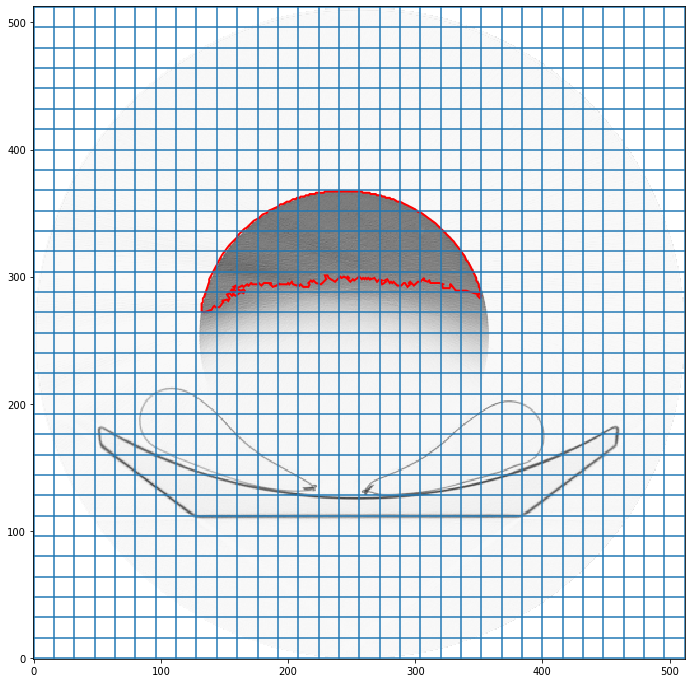

In [7]:
# 2D DISPLAY OF THE CONTOUR
# For display purposes, we need to switch from the image axes to the display axes


# Display and calculation Grid definition:
# default calculation resolution: CT pixel size
grid_min = (0,0)
grid_size = (sizeX,sizeY)
step = (1,1)
visFactor = 16
grid_max = ((grid_min[0]+grid_size[0]*step[0]), (grid_min[1]+grid_size[1]*step[1]))


# Matplotlib figure
fig = plt.figure(figsize=(12,12))
ax = plt.axes()
ax.set_xlim(grid_min[0]-0.5*step[0], grid_max[0]+0.5*step[0])
ax.set_ylim(grid_min[1]-0.5*step[1], grid_max[1]+0.5*step[1])


# Displays the CT on the backgroud of the image
ax.imshow(np.flip(pixArray, 0), cmap="Greys", interpolation="nearest", 
          vmin = -100, vmax = 2000)

# Displays the lines
for i in np.arange(grid_min[0], grid_min[0] + (grid_size[0]+1)*step[0], step[0]*visFactor):
    line = plt.Line2D((i,i),(grid_min[1],grid_max[1]))
    ax.add_line(line)

for j in np.arange(grid_min[1], grid_min[1] + (grid_size[1]+1)*step[1], step[1]*visFactor):
    line2 = plt.Line2D((grid_min[0],grid_max[0]),(j,j))
    ax.add_line(line2)


# Creation of the contour:
cc = coordConverter(xOrigin, yOrigin, xSpacing, ySpacing, sizeX, sizeY)
dispPointList = cc.converStructList(pointList)
path_contour = matplotlib.path.Path(dispPointList)

# Plots the contour
polygone = plt.Polygon(dispPointList, fill=False, color = "red", linewidth=2)
ax.add_patch(polygone)
